In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv("shared/complaints_25Nov21.csv")

In [5]:
df=df.fillna('missing')

In [6]:
#q2
selected_columns = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']
X = df[selected_columns]
le = preprocessing.LabelEncoder()
df['Consumer disputed?'] = le.fit_transform(df['Consumer disputed?'])
X_train, X_test, y_train, y_test = train_test_split(X, df['Consumer disputed?'], test_size=0.2, random_state=123)
train_data = pd.concat([X_train, y_train], axis=1)
disputed_samples = train_data[train_data['Consumer disputed?'] == 1]
not_disputed_samples = train_data[train_data['Consumer disputed?'] == 0]
undersampled_not_disputed = resample(not_disputed_samples, 
                                     replace=False,  
                                     n_samples=len(disputed_samples),  
                                     random_state=123)
undersampled_train_data = pd.concat([disputed_samples, undersampled_not_disputed])
dispute_proportion_undersampled = sum(undersampled_train_data['Consumer disputed?']) / len(undersampled_train_data)
print("Proportion of consumers who raised a dispute in the undersampled training dataset: {:.2f}".format(dispute_proportion_undersampled))

Proportion of consumers who raised a dispute in the undersampled training dataset: 0.50


In [22]:
#q1
dispute_proportion = sum(y_test) / len(y_test)

print("Proportion of consumers who raised a dispute in the test set: {:.5f}".format(dispute_proportion))

Proportion of consumers who raised a dispute in the test set: 0.21586


In [32]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=123)

X_train, y_train = undersampler.fit_resample(X_encoded, y)

In [30]:
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452



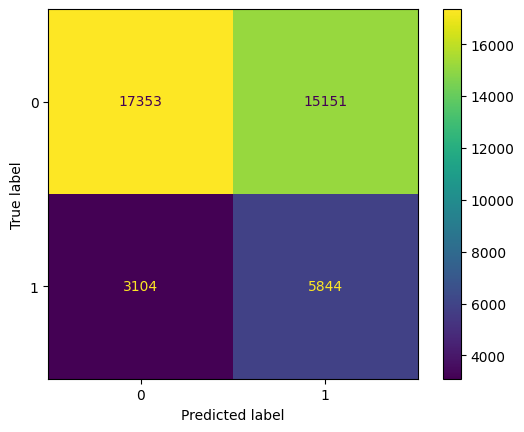

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
pred= model_xgb.predict(X_test)

print(classification_report(y_true=y_test,y_pred=pred))
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test);

In [11]:
#q4
not_disputed_count = (y_test == 0).sum()

disputed_count = (y_test == 1).sum()

cost_per_not_disputed = 100

cost_per_disputed = 600

total_cost = (not_disputed_count * cost_per_not_disputed) + (disputed_count * cost_per_disputed)

print("Total cost to the banks without using the model:", total_cost)


Total cost to the banks without using the model: 8619200


In [36]:
#5

100*17353+15151*190+3104*600+5844*190


7586750

In [47]:
#6
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

threshold_range = np.linspace(0, 1, 101)

best_threshold = None
min_total_cost = float('inf')

for threshold in threshold_range:
   
    adjusted_predictions = (model_xgb.predict_proba(X_test)[:, 1] > threshold).astype(int)
    tn,fp,fn,tp=confusion_matrix(y_test,adjusted_predictions).ravel()

    
    total_cost = tp*190+fp*190+fn*600+tn*100
  
    if total_cost < min_total_cost:
        min_total_cost = total_cost
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Minimum total cost:", min_total_cost)

Best threshold: 0.46
Minimum total cost: 7491540
